<a href="https://colab.research.google.com/github/duc19102022/pytorch_tutorial/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# convert MNIST Image files into a tensor of 4-demensions (# of images, Height, Width, Color channels)
transform = transforms.ToTensor()

In [3]:
# Train Data
train_data = datasets.MNIST(root='/cnn_data',train=True, download=True,transform=transform)

In [4]:
# Test Data
test_data = datasets.MNIST(root='/cnn_data',train=False,download=True,transform=transform)


In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# create a small batch size for images ... let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# define our cnn model
# describe convolutional layer and what it's doing (2 convulutional layers)
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)
# conv3 = nn.Conv2d()

In [9]:
# grab 1 MNIST record/image
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [10]:
X_Train.shape

torch.Size([1, 28, 28])

In [11]:
x = X_Train.view(1,1,28,28)

In [12]:
# perform our first convolution
x = F.relu(conv1(x))

In [13]:
# 1 single image, 6 is the filters we asked for, 26x26
# we didn't set padding so we lose 2 pixles around outside
x.shape

torch.Size([1, 6, 26, 26])

In [14]:
x = F.max_pool2d(x,2,2)
# kernal of 2 and stride of 2

In [15]:
x.shape

torch.Size([1, 6, 13, 13])

In [16]:
# do our second convolutional layer
x = F.relu(conv2(x))

In [17]:
x.shape

torch.Size([1, 16, 11, 11])

In [18]:
x = F.max_pool2d(x,2,2)

In [19]:
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Full connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    #  Re_view to flatten it out
    X = X.view(-1,16*5*5)
    # Fully connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [21]:
# creat an instance of models
torch.manual_seed(41)
model = ConvolutionalNetwork()
print(model)

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [22]:
# loss funciton optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [23]:
import time
start_time = time.time()

# create variables to tracks things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # train
  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions.
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch.
    trn_corr += batch_corr # keep track as we go along in training

    # update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch:{b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'training took: {total/60} minutes')

Epoch: 0  Batch:600  Loss: 0.01122160442173481
Epoch: 0  Batch:1200  Loss: 0.5097795128822327
Epoch: 0  Batch:1800  Loss: 0.27345114946365356
Epoch: 0  Batch:2400  Loss: 0.5706523656845093
Epoch: 0  Batch:3000  Loss: 0.010505528189241886
Epoch: 0  Batch:3600  Loss: 0.1338011920452118
Epoch: 0  Batch:4200  Loss: 0.0005176571430638433
Epoch: 0  Batch:4800  Loss: 0.10394303500652313
Epoch: 0  Batch:5400  Loss: 0.2622598111629486
Epoch: 0  Batch:6000  Loss: 0.0009407080942764878
Epoch: 1  Batch:600  Loss: 0.010575367137789726
Epoch: 1  Batch:1200  Loss: 0.004694225732237101
Epoch: 1  Batch:1800  Loss: 0.06041830778121948
Epoch: 1  Batch:2400  Loss: 0.08412185311317444
Epoch: 1  Batch:3000  Loss: 1.2497214078903198
Epoch: 1  Batch:3600  Loss: 0.5397676229476929
Epoch: 1  Batch:4200  Loss: 0.005220157094299793
Epoch: 1  Batch:4800  Loss: 0.0007686594035476446
Epoch: 1  Batch:5400  Loss: 0.0005603323224931955
Epoch: 1  Batch:6000  Loss: 0.08629796653985977
Epoch: 2  Batch:600  Loss: 0.6476114

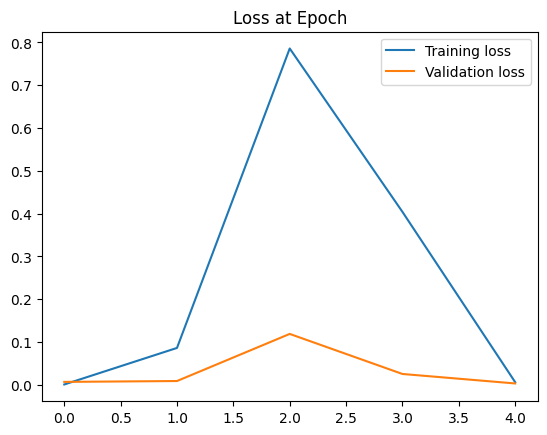

In [24]:
# graph th loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at Epoch')
plt.legend()

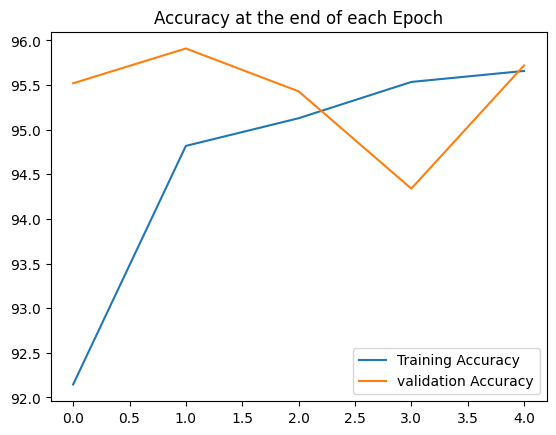

In [25]:
# graph the accuracy at the end of each epoch

plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [26]:
test_load_everything = DataLoader(test_data, batch_size=1000, shuffle=False)

In [27]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()


In [28]:
correct.item()/len(test_data)*100

95.72

In [34]:
# grab an image
test_data[8888]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2314,
           0.9373, 0.8745, 0.1373, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6118,
           0.9922, 0.9922, 0.4275, 0.0000, 

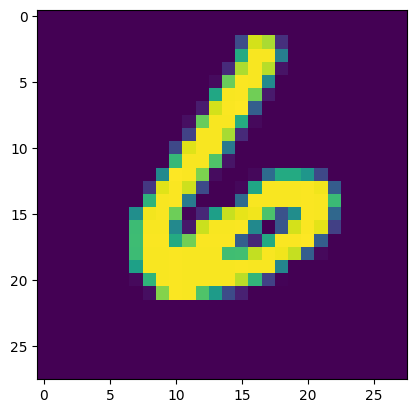

In [35]:
# show image
plt.imshow(test_data[8888][0].reshape(28,28))

In [36]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[8888][0].view(1,1,28,28))
new_prediction

tensor([[-20.6895, -24.5527, -23.9863, -40.0851, -22.9320, -19.1753,   0.0000,
         -51.4457, -20.7555, -47.0425]])

In [37]:
torch.argmax(new_prediction)

tensor(6)